In [0]:
import numpy as np
import scipy.sparse as sp
import math
import pickle
import matplotlib.pyplot as plt

In [0]:
class Node:
    def __init__(self,indices,t_indices,v_indices,depth):
        self.indices = indices #contains all the index for all of training data to be processes by the node
        self.v_indices = v_indices #contains all the index for all of validation data to be processes by the node
        self.t_indices = t_indices #contains all the index for all of testing data to be processes by the node 
        self.attribute = None #at what attribute (best) we splitted (if not leaf)
        self.left = None #list of all the children nodes at which we splitted this
        self.right = None
        self.aval = None #label assigned to the node (if leaf)
        self.depth = depth #depth at each node
        self.label = None
        self.below = None
        self.v_below = None
        self.t_below = None
        self.itself = None
        self.v_itself = None
        self.t_itself = None
        return

    def add_child(self,l,lt,lv,r,rt,rv,attribute,aval,label):
        self.left = Node(l,lt,lv,self.depth+1)
        self.right = Node(r,rt,rv,self.depth+1)
        self.attribute = attribute
        self.aval = aval
        self.label = label
        return
    
    def add_label(self,label):
        self.label = label
        return

  

In [0]:
def get_entropy(datay):
    countpos = np.sum(datay)
    countneg = datay.size - countpos
    p0 = (countneg * 1.0) / (countneg + countpos)
    p1 = 1.0 - p0
    try:
        val = ((p0 * math.log(p0, 2)) + (p1 * math.log(p1, 2)))
    except:
        val = 0.0 #takes the value 0 in the limiting case
    return (-1.0 * val)

In [0]:
def cond_entropy(data):
    med = np.median(data[:,0])
    l = data[data[:,0]<=med]
    r = data[data[:,0]>med]
    pl = float(len(l))/(len(l)+len(r))
    pr = 1.-pl
    if (len(l)>0 and len(r)>0):
        ce = pl*get_entropy(l[:,1])+pr*get_entropy(r[:,1])
    else:
        ce = math.inf
    return ce,med,l[:,2],r[:,2]

In [0]:
def choose_best_feature(indices):
    data = train[indices,482]
    h = get_entropy(data)
    p1 = np.sum(data)
    label = 0
    if p1*2 > len(data):
        label = 1
    in_data = np.zeros((len(data),3),dtype = 'int')
    in_data[:,0] = train[indices,0]
    in_data[:,1] = train[indices,482]
    in_data[:,2] = train[indices,483]
    ce,med,li,ri = cond_entropy(in_data)
    mi = h - ce
    index = 0
    for i in range(1,482):
        in_data[:,0] = train[indices,i]
        ce_temp,med_temp,li_temp,ri_temp = cond_entropy(in_data)
        mi_temp = h - ce_temp
        if mi<mi_temp:
            mi = mi_temp
            index= i
            li = li_temp
            ri = ri_temp
            med = med_temp
    return mi,index,med,li,ri,label

In [0]:
def generate_tree(node,a,ta,va):
    global num_nodes
    global h_depth
    global nodes
    global acc
    global tacc
    global vacc
    global cacc
    global ctacc
    global cvacc
    num_nodes += 1
    if node.depth > h_depth:
        h_depth = node.depth 
    mi,att,med,l,r,label = choose_best_feature(node.indices)
    nodes.append(num_nodes)
    a1 = train[node.indices,482]
    a1 = a1[a1[:] == label]
    ta1 = test[node.t_indices,482]
    ta1 = ta1[ta1[:] == label]
    va1 = valid[node.v_indices,482]
    va1 = va1[va1[:] == label]
    cacc += len(a1)-a
    ctacc += len(ta1)-ta
    cvacc += len(va1)-va
    acc.append(cacc)
    tacc.append(ctacc)
    vacc.append(cvacc)
    
    if len(l>0) and len(r)>0 and mi>0:
        lv = node.v_indices[valid[node.v_indices,att]<=med]
        rv = node.v_indices[valid[node.v_indices,att]>med]
        lt = node.t_indices[test[node.t_indices,att]<=med]
        rt = node.t_indices[test[node.t_indices,att]>med]
        node.add_child(l,lt,lv,r,rt,rv,att,med,label)
    else: 
        node.add_label(label)
    if node.left != None:
        a1 = train[node.left.indices,482]
        a1 = a1[a1[:] == label]
        ta1 = test[node.left.t_indices,482]
        ta1 = ta1[ta1[:] == label]
        va1 = valid[node.left.v_indices,482]
        va1 = va1[va1[:] == label]        
        generate_tree(node.left,len(a1),len(ta1),len(va1))
    if node.right != None:
        a1 = train[node.right.indices,482]
        a1 = a1[a1[:] == label]
        ta1 = test[node.right.t_indices,482]
        ta1 = ta1[ta1[:] == label]
        va1 = valid[node.right.v_indices,482]
        va1 = va1[va1[:] == label]
        generate_tree(node.right,len(a1),len(ta1),len(va1))
 
    return

In [0]:
pickle_in = open("/content/drive/My Drive/train.pk","rb")
trainx = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/My Drive/test.pk","rb")
testx = pickle.load(pickle_in)
pickle_in.close()

pickle_in = open("/content/drive/My Drive/valid.pk","rb")
validx = pickle.load(pickle_in)
pickle_in.close()

Training  Completed!!!!!!!
19977
52


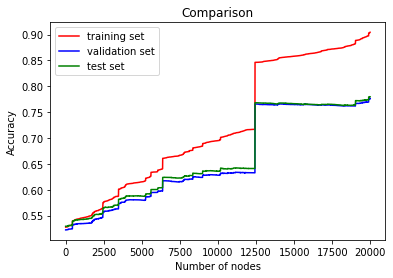

In [81]:
# Read file with y data
trainy = []
testy = []
validy = []

trainy = np.loadtxt('/content/drive/My Drive/train_y.txt',dtype = 'int')
# print(trainy.shape)
testy = np.loadtxt('/content/drive/My Drive/test_y.txt',dtype = 'int')
# print(testy.shape)
validy = np.loadtxt('/content/drive/My Drive/valid_y.txt',dtype = 'int')
# print(validy.shape)

row_train,col_train = trainx.shape
train = np.zeros((row_train,col_train+2),dtype = 'int')
train[:,:col_train] = np.array(trainx,dtype = 'int')
train[:,col_train] = trainy
train[:,col_train+1] = np.arange(row_train)

row_valid,col_valid = validx.shape
valid = np.zeros((row_valid,col_valid+2),dtype = 'int')
valid[:,:col_valid] = np.array(validx,dtype = 'int')
valid[:,col_valid] = validy
valid[:,col_train+1] = np.arange(row_valid)

row_test,col_test = testx.shape
test = np.zeros((row_test,col_test+2),dtype = 'int')
test[:,:col_test] = np.array(testx,dtype = 'int')
test[:,col_test] = testy
test[:,col_test+1] = np.arange(row_test)

nodes = []
acc = []
tacc = []
vacc = []
cacc = 0
ctacc = 0
cvacc = 0
num_nodes=0
h_depth = 0
root = Node(train[:,483],test[:,483],valid[:,483],0)
generate_tree(root,0,0,0)
print("Training  Completed!!!!!!!")
print(num_nodes)
print(h_depth)
acc = np.array(acc,dtype = 'float')
tacc = np.array(tacc,dtype = 'float')
vacc = np.array(vacc,dtype = 'float')
acc = acc/len(train)
tacc = tacc/len(test)
vacc = vacc/len(valid)
# plot for comaparison
plt.plot(nodes,acc,color='red', label='training set')
plt.plot(nodes,vacc, color='blue', label='validation set')
plt.plot(nodes,tacc, color='green', label='test set')
plt.title('Comparison')
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('/content/plot_comparison.png')
plt.close()

Training set accuracy: 0.9043932440158855


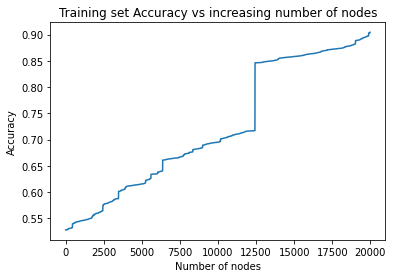

Training set accuracy 0.779843308145195


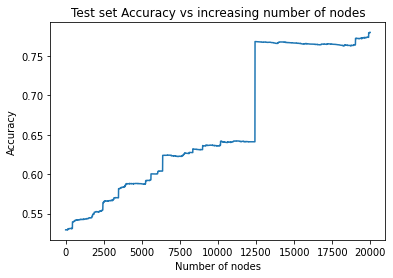

Validation set accuracy 0.7761913591692935


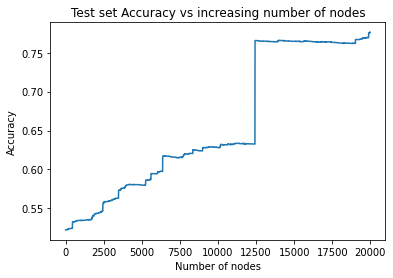

In [82]:
print("Training set accuracy:", acc[-1])
plt.title('Training set Accuracy vs increasing number of nodes')
plt.plot(nodes,acc)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

print("Training set accuracy", tacc[-1])
plt.title('Test set Accuracy vs increasing number of nodes')
plt.plot(nodes,tacc)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

print("Validation set accuracy", vacc[-1])
plt.title('Test set Accuracy vs increasing number of nodes')
plt.plot(nodes,vacc)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

In [0]:
# pruning 
def prune(node):
    global cacc
    global ctacc
    global cvacc
    global acc
    global tacc
    global vacc
    global nodes
    global num_nodes

    datay = train[node.indices,482]
    datay = datay[datay[:] == node.label]
    node.itself = len(datay) 
    
    datay = valid[node.v_indices,482]
    datay = datay[datay[:] == node.label]
    node.v_itself = len(datay) 

    datay = test[node.t_indices,482]
    datay = datay[datay[:] == node.label]
    node.t_itself = len(datay) 


    if node.left != None and node.right != None:
        prune(node.left)
        prune(node.right)
        node.below = node.right.below+node.left.below
        node.v_below = node.right.v_below+node.left.v_below
        node.t_below = node.right.t_below+node.left.t_below
    else:
        node.below = node.itself
        node.v_below = node.v_itself
        node.t_below = node.t_itself
    if node.v_below<=node.v_itself and node.left != None and node.right != None:
        node.left = None
        node.right = None
        num_nodes -= 2
        nodes.append(num_nodes)
        cacc += node.itself-node.below
        acc.append(cacc)
        ctacc += node.t_itself-node.t_below
        tacc.append(ctacc)
        cvacc += node.v_itself-node.v_below
        vacc.append(cvacc)
        node.below = node.itself
        node.v_below = node.v_itself
        node.t_below = node.t_itself
    return 



In [0]:
# do pruning
nodes = [nodes[-1]]
acc = [cacc]
tacc = [ctacc]
vacc = [cvacc]
prune(root)
acc = np.array(acc,dtype = 'float')
tacc = np.array(tacc,dtype = 'float')
vacc = np.array(vacc,dtype = 'float')
acc = acc/len(train)
tacc = tacc/len(test)
vacc = vacc/len(valid)
print(nodes[-1])
print(acc[-1])
print(vacc[-1])
print(tacc[-1])

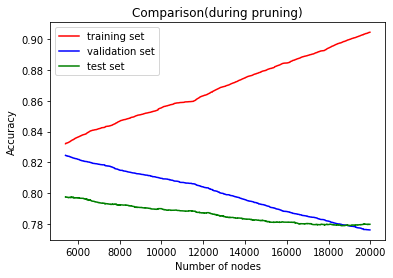

Training set accuracy: 0.8321048321048321


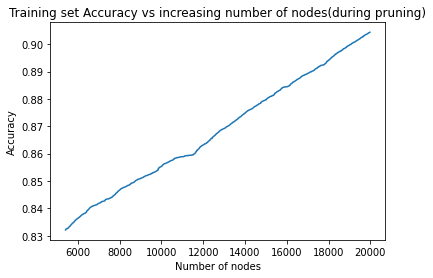

Training set accuracy 0.7975522692503825


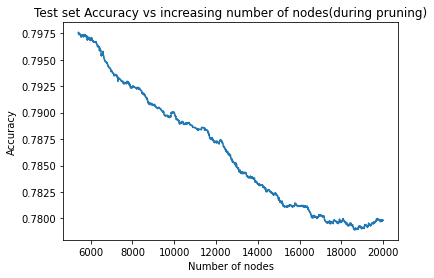

Validation set accuracy 0.8245410717596885


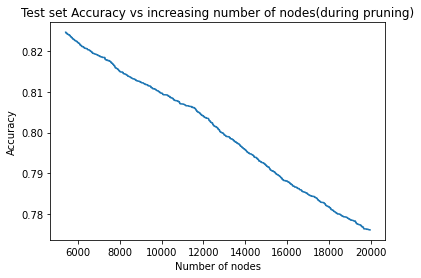

In [87]:
# plot for comaparison
plt.plot(nodes,acc,color='red', label='training set')
plt.plot(nodes,vacc, color='blue', label='validation set')
plt.plot(nodes,tacc, color='green', label='test set')
plt.title('Comparison(during pruning)')
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
plt.savefig('/content/plot_comparison.png')
plt.close()

print("Training set accuracy:", acc[-1])
plt.title('Training set Accuracy vs increasing number of nodes(during pruning)')
plt.plot(nodes,acc)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

print("Training set accuracy", tacc[-1])
plt.title('Test set Accuracy vs increasing number of nodes(during pruning)')
plt.plot(nodes,tacc)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

print("Validation set accuracy", vacc[-1])
plt.title('Test set Accuracy vs increasing number of nodes(during pruning)')
plt.plot(nodes,vacc)
plt.xlabel('Number of nodes')
plt.ylabel('Accuracy')
plt.show()
plt.savefig('/content/drive/My Drive/plot_train.png')
plt.close()

